# Business Problem
Timely and accurate diagnosis of pneumonia remains a critical challenge for hospitals and diagnostic centres, especially where radiologist resources are limited and patient volumes are high.This can eventually lead to slower treatment initiation, prolonged hospital stays, and higher healthcare costs which lead to negative patient experiences and hospital efficiency.

The aim of this task is to provide a solution to this problem by designing a model that will automate pneumonia detection thereby allowing radiologists to prioritze high-cases. This will help reduce reporting turnaround times, and eventually improve both clinical outcomes and operational performance.

The data for this task was collected from **Kaggle** and it contains thousands of labeled images of normal and pneumonia cases. This task will be formulated as a supervised machine learning problem: a binary classification task where the aim is to train a deep neural network that can accurately differentiate between normal and pneumonia chest x-rays based on image features.

The link to the dataset is https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

**First, the libraries required for this machine learning task are imported**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

**The datset is also imported**

In [2]:
import zipfile

zip_path = '/content/drive/MyDrive/chest_xray.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"'{zip_path}' extracted to '{extract_path}'")

'/content/drive/MyDrive/chest_xray.zip' extracted to '/content/'


# Data Exploration

**The images in the dataset are already split into training, validation and test sets to facilitate model development and unbiased evaluation**


The chest x-ray dataset contains more than 5800 labeled chest x-ray images which have been divided into two classes - Normal and Pneumonia, with separate training, validation, and test splits.

In [3]:
train_dir = "chest_xray/train"
val_dir   = "chest_xray/val"
test_dir  = "chest_xray/test"

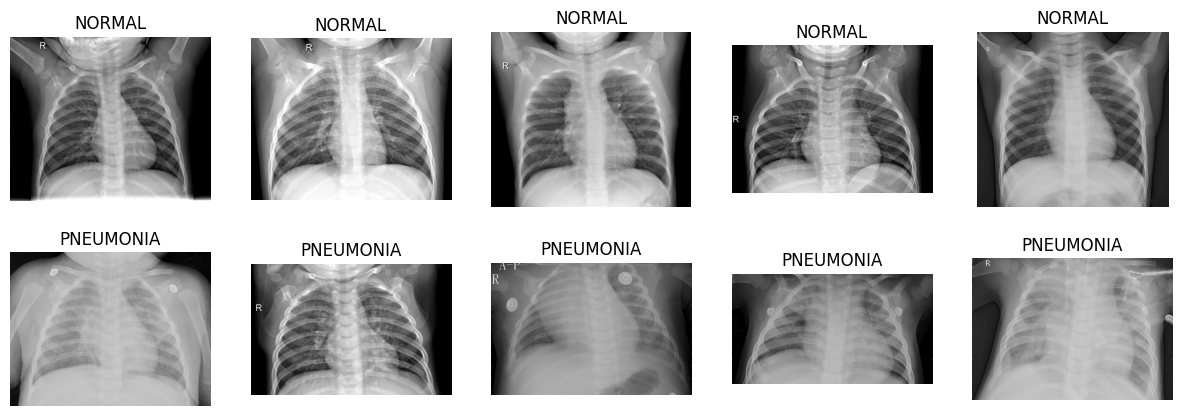

In [4]:
def plot_sample_images(directory, classes, n_samples=5):
    plt.figure(figsize=(15,5))
    for i, cls in enumerate(classes):
        cls_dir = os.path.join(directory, cls)
        imgs = os.listdir(cls_dir)[:n_samples]
        for j, img in enumerate(imgs):
            plt.subplot(len(classes), n_samples, i*n_samples + j + 1)
            plt.imshow(plt.imread(os.path.join(cls_dir,img)), cmap='gray')
            plt.title(cls)
            plt.axis('off')
    plt.show()

classes = ['NORMAL', 'PNEUMONIA']
plot_sample_images(train_dir, classes)

The images come from different patients and vary in size, resolution and brightness. Some images may be noisier or have low quality, which may require preprocessing(resizing, normalization) and data augmentation to improve model generalization.

# Data Preprocessing and Augmentation
In order to handle variability and improve model generalization, the following steps will be applied:

1.   Resizing: All images will be resized to 224x224 pixels to match the input requirements of the neural network(EfficientNetB0).
2.   Normalization: Pixel values will be scaled to the [0,1] range for faster and more stable training.
3. Data Augmentation: Random rotations, horizontal flips, zooms and brightness adjustments will be applied to increase variability and reduce overfitting.



In [5]:
def get_datagen(aug_type, img_size=(224,224), batch_size=32):
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    if aug_type is None:
        train_datagen = ImageDataGenerator(rescale=1./255)
    elif aug_type == "rotation":
        train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15)
    elif aug_type == "flip":
        train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
    elif aug_type == "zoom":
        train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.1)
    elif aug_type == "all":
        train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, horizontal_flip=True, zoom_range=0.1)
    elif aug_type == "rotation+flip":
        train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, horizontal_flip=True)
    elif aug_type == "rotation+zoom":
        train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, zoom_range=0.1)
    elif aug_type == "flip+zoom":
        train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.1)
    elif aug_type == "rotation+flip+zoom":
        train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, horizontal_flip=True, zoom_range=0.1)

    train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=batch_size, class_mode='binary'
    )

    val_gen = val_test_datagen.flow_from_directory(
        val_dir, target_size=img_size, batch_size=batch_size, class_mode='binary'
    )

    test_gen = val_test_datagen.flow_from_directory(
        test_dir, target_size=img_size, batch_size=batch_size, class_mode='binary', shuffle=False
    )

    return train_gen, val_gen, test_gen

# Eperiments and Validation Results

To identify the optimal pipeline for pneumonia detection, experiments will be conducted across 10 different configurations, varying data augmentation, model architecture, learning rate, and batch size. Each configuration will be evaluated on the validation set, and the impact of each design choice on performance will be recorded.

In [6]:
experiment_configs = [
    {"aug": None,                     "model_type": "EfficientNetB0", "lr": 1e-4, "batch_size": 32, "epochs": 10},
    {"aug": "rotation",               "model_type": "EfficientNetB0", "lr": 1e-4, "batch_size": 32, "epochs": 10},
    {"aug": "flip",                   "model_type": "EfficientNetB0", "lr": 1e-4, "batch_size": 32, "epochs": 10},
    {"aug": "zoom",                   "model_type": "EfficientNetB0", "lr": 1e-4, "batch_size": 32, "epochs": 10},
    {"aug": "all",                    "model_type": "EfficientNetB0", "lr": 1e-4, "batch_size": 32, "epochs": 10},
    {"aug": "rotation+flip",          "model_type": "ResNet50",       "lr": 1e-4, "batch_size": 32, "epochs": 10},
    {"aug": "rotation+zoom",          "model_type": "ResNet50",       "lr": 1e-4, "batch_size": 32, "epochs": 10},
    {"aug": "flip+zoom",              "model_type": "ResNet50",       "lr": 1e-4, "batch_size": 32, "epochs": 10},
    {"aug": "rotation+flip+zoom",     "model_type": "ResNet50",       "lr": 1e-4, "batch_size": 32, "epochs": 10},
    {"aug": "rotation+flip+zoom",     "model_type": "EfficientNetB0", "lr": 5e-5, "batch_size": 16, "epochs": 15},
]

# Initialize results DataFrame
results = pd.DataFrame(columns=["Config","Augmentation","Model Type","Learning Rate","Batch Size","Epochs","Val Accuracy"])


**Running Experiments**

In [7]:
for i, cfg in enumerate(experiment_configs):
    print(f"\n===== Experiment {i+1} =====")
    train_gen, val_gen, test_gen = get_datagen(cfg["aug"], batch_size=cfg["batch_size"])

    # Model selection
    if cfg["model_type"] == "EfficientNetB0":
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
    else:
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=Adam(cfg["lr"]), loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

    history = model.fit(train_gen, validation_data=val_gen, epochs=cfg["epochs"], callbacks=[early_stop, reduce_lr], verbose=1)

    best_val_acc = max(history.history['val_accuracy'])
    results.loc[i] = [i+1, cfg["aug"], cfg["model_type"], cfg["lr"], cfg["batch_size"], cfg["epochs"], round(best_val_acc,4)]

    # Display results table
    display(results)


===== Experiment 1 =====
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 382ms/step - accuracy: 0.7108 - loss: 0.5932 - val_accuracy: 0.5000 - val_loss: 0.8246 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 300ms/step - accuracy: 0.7395 - loss: 0.5793 - val_accuracy: 0.5000 - val_loss: 0.8326 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 289ms/step - accuracy: 0.7406 - loss: 0.5762 - val_accuracy: 0.5000 - val_loss: 0.8109 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 294ms/step - accuracy: 0.7371 - loss: 0.5788 - val_accuracy: 0.5000 - val_loss: 0.8430 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 286ms/step - accuracy: 0.7455 - loss: 0.5700 - val_accuracy: 0.5000 - val_loss: 0.7957 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 297ms/step - accuracy: 0.7453 - loss: 0.5707 - val_accuracy: 0.5000 - val_loss: 0.8521 - learning_rate: 1.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 28

,Config,Augmentation,Model Type,Learning Rate,Batch Size,Epochs,Val Accuracy
0,1,None,EfficientNetB0,0.0001,32,10,0.5



===== Experiment 2 =====
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 647ms/step - accuracy: 0.7360 - loss: 0.5857 - val_accuracy: 0.5000 - val_loss: 0.8086 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 596ms/step - accuracy: 0.7386 - loss: 0.5837 - val_accuracy: 0.5000 - val_loss: 0.8154 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 604ms/step - accuracy: 0.7450 - loss: 0.5723 - val_accuracy: 0.5000 - val_loss: 0.7986 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 601ms/step - accuracy: 0.7410 - loss: 0.5788 - val_accuracy: 0.5000 - val_loss: 0.8605 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 591ms/step - accuracy: 0.7395 - loss: 0.5787 - val_accuracy: 0.5000 - val_loss: 0.8040 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 594ms/step - accuracy: 0.7402 - loss: 0.5737 - val_accuracy: 0.5000 - val_loss: 0.8338 - learning_rate: 5.0000e-05


,Config,Augmentation,Model Type,Learning Rate,Batch Size,Epochs,Val Accuracy
0,1,None,EfficientNetB0,0.0001,32,10,0.5
1,2,rotation,EfficientNetB0,0.0001,32,10,0.5



===== Experiment 3 =====
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 338ms/step - accuracy: 0.7355 - loss: 0.5878 - val_accuracy: 0.5000 - val_loss: 0.8359 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 297ms/step - accuracy: 0.7448 - loss: 0.5726 - val_accuracy: 0.5000 - val_loss: 0.8297 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 292ms/step - accuracy: 0.7558 - loss: 0.5594 - val_accuracy: 0.5000 - val_loss: 0.8262 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 298ms/step - accuracy: 0.7510 - loss: 0.5644 - val_accuracy: 0.5000 - val_loss: 0.8209 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 292ms/step - accuracy: 0.7499 - loss: 0.5686 - val_accuracy: 0.5000 - val_loss: 0.8032 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 292ms/step - accuracy: 0.7558 - loss: 0.5596 - val_accuracy: 0.5000 - val_loss: 0.7721 - learning_rate: 1.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 29

,Config,Augmentation,Model Type,Learning Rate,Batch Size,Epochs,Val Accuracy
0,1,None,EfficientNetB0,0.0001,32,10,0.5
1,2,rotation,EfficientNetB0,0.0001,32,10,0.5
2,3,flip,EfficientNetB0,0.0001,32,10,0.5



===== Experiment 4 =====
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 124s 628ms/step - accuracy: 0.7033 - loss: 0.5928 - val_accuracy: 0.5000 - val_loss: 0.8631 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 597ms/step - accuracy: 0.7520 - loss: 0.5656 - val_accuracy: 0.5000 - val_loss: 0.8175 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 599ms/step - accuracy: 0.7421 - loss: 0.5716 - val_accuracy: 0.5000 - val_loss: 0.8682 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 596ms/step - accuracy: 0.7492 - loss: 0.5688 - val_accuracy: 0.5000 - val_loss: 0.8431 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 593ms/step - accuracy: 0.7380 - loss: 0.5785 - val_accuracy: 0.5000 - val_loss: 0.8063 - learning_rate: 5.0000e-05
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 605ms/step - accuracy: 0.7488 - loss: 0.5695 - val_accuracy: 0.5000 - val_loss: 0.7933 - learning_rate: 5.0000e-05
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 5

,Config,Augmentation,Model Type,Learning Rate,Batch Size,Epochs,Val Accuracy
0,1,None,EfficientNetB0,0.0001,32,10,0.5
1,2,rotation,EfficientNetB0,0.0001,32,10,0.5
2,3,flip,EfficientNetB0,0.0001,32,10,0.5
3,4,zoom,EfficientNetB0,0.0001,32,10,0.5



===== Experiment 5 =====
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 122s 629ms/step - accuracy: 0.7233 - loss: 0.5916 - val_accuracy: 0.5000 - val_loss: 0.8802 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 589ms/step - accuracy: 0.7454 - loss: 0.5701 - val_accuracy: 0.5000 - val_loss: 0.8135 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 602ms/step - accuracy: 0.7543 - loss: 0.5625 - val_accuracy: 0.5000 - val_loss: 0.8385 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 602ms/step - accuracy: 0.7512 - loss: 0.5628 - val_accuracy: 0.5000 - val_loss: 0.8264 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 596ms/step - accuracy: 0.7510 - loss: 0.5637 - val_accuracy: 0.5000 - val_loss: 0.7915 - learning_rate: 5.0000e-05
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 602ms/step - accuracy: 0.7415 - loss: 0.5757 - val_accuracy: 0.5000 - val_loss: 0.8533 - learning_rate: 5.0000e-05
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 6

,Config,Augmentation,Model Type,Learning Rate,Batch Size,Epochs,Val Accuracy
0,1,None,EfficientNetB0,0.0001,32,10,0.5
1,2,rotation,EfficientNetB0,0.0001,32,10,0.5
2,3,flip,EfficientNetB0,0.0001,32,10,0.5
3,4,zoom,EfficientNetB0,0.0001,32,10,0.5
4,5,all,EfficientNetB0,0.0001,32,10,0.5



===== Experiment 6 =====
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 121s 649ms/step - accuracy: 0.6766 - loss: 0.6464 - val_accuracy: 0.5000 - val_loss: 0.8366 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 623ms/step - accuracy: 0.7404 - loss: 0.5826 - val_accuracy: 0.5000 - val_loss: 0.7617 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 617ms/step - accuracy: 0.7347 - loss: 0.5766 - val_accuracy: 0.5000 - val_loss: 0.7684 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 617ms/step - accuracy: 0.7496 - loss: 0.5462 - val_accuracy: 0.5000 - val_loss: 0.7432 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 631ms/step - accuracy: 0.7346 - loss: 0.5379 - val_accuracy: 0.5000 - val_loss: 0.7514 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 611ms/step - accuracy: 0.7411 - loss: 0.5413 - val_accuracy: 0.5000 - val_loss: 0.7570 - learning_rate: 1.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 

,Config,Augmentation,Model Type,Learning Rate,Batch Size,Epochs,Val Accuracy
0,1,None,EfficientNetB0,0.0001,32,10,0.5000
1,2,rotation,EfficientNetB0,0.0001,32,10,0.5000
2,3,flip,EfficientNetB0,0.0001,32,10,0.5000
3,4,zoom,EfficientNetB0,0.0001,32,10,0.5000
4,5,all,EfficientNetB0,0.0001,32,10,0.5000
5,6,rotation+flip,ResNet50,0.0001,32,10,0.5625



===== Experiment 7 =====
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 654ms/step - accuracy: 0.7135 - loss: 0.6218 - val_accuracy: 0.5000 - val_loss: 0.7357 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 629ms/step - accuracy: 0.7359 - loss: 0.5845 - val_accuracy: 0.5000 - val_loss: 0.7583 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 627ms/step - accuracy: 0.7376 - loss: 0.5723 - val_accuracy: 0.5000 - val_loss: 0.7363 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 633ms/step - accuracy: 0.7417 - loss: 0.5486 - val_accuracy: 0.5000 - val_loss: 0.7134 - learning_rate: 5.0000e-05
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 630ms/step - accuracy: 0.7498 - loss: 0.5398 - val_accuracy: 0.5000 - val_loss: 0.6963 - learning_rate: 5.0000e-05
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 631ms/step - accuracy: 0.7487 - loss: 0.5352 - val_accuracy: 0.5000 - val_loss: 0.7043 - learning_rate: 5.0000e-05
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 

,Config,Augmentation,Model Type,Learning Rate,Batch Size,Epochs,Val Accuracy
0,1,None,EfficientNetB0,0.0001,32,10,0.5000
1,2,rotation,EfficientNetB0,0.0001,32,10,0.5000
2,3,flip,EfficientNetB0,0.0001,32,10,0.5000
3,4,zoom,EfficientNetB0,0.0001,32,10,0.5000
4,5,all,EfficientNetB0,0.0001,32,10,0.5000
5,6,rotation+flip,ResNet50,0.0001,32,10,0.5625
6,7,rotation+zoom,ResNet50,0.0001,32,10,0.5625



===== Experiment 8 =====
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 643ms/step - accuracy: 0.7096 - loss: 0.6124 - val_accuracy: 0.5000 - val_loss: 0.7902 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 610ms/step - accuracy: 0.7270 - loss: 0.5799 - val_accuracy: 0.5000 - val_loss: 0.7621 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 623ms/step - accuracy: 0.7398 - loss: 0.5592 - val_accuracy: 0.5000 - val_loss: 0.7216 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 614ms/step - accuracy: 0.7469 - loss: 0.5392 - val_accuracy: 0.5000 - val_loss: 0.7128 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 623ms/step - accuracy: 0.7478 - loss: 0.5302 - val_accuracy: 0.5625 - val_loss: 0.6787 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 609ms/step - accuracy: 0.7539 - loss: 0.5237 - val_accuracy: 0.5625 - val_loss: 0.6947 - learning_rate: 1.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10

,Config,Augmentation,Model Type,Learning Rate,Batch Size,Epochs,Val Accuracy
0,1,None,EfficientNetB0,0.0001,32,10,0.5000
1,2,rotation,EfficientNetB0,0.0001,32,10,0.5000
2,3,flip,EfficientNetB0,0.0001,32,10,0.5000
3,4,zoom,EfficientNetB0,0.0001,32,10,0.5000
4,5,all,EfficientNetB0,0.0001,32,10,0.5000
5,6,rotation+flip,ResNet50,0.0001,32,10,0.5625
6,7,rotation+zoom,ResNet50,0.0001,32,10,0.5625
7,8,flip+zoom,ResNet50,0.0001,32,10,0.6250



===== Experiment 9 =====
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 119s 652ms/step - accuracy: 0.6202 - loss: 0.7288 - val_accuracy: 0.5000 - val_loss: 0.8031 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 618ms/step - accuracy: 0.7350 - loss: 0.5903 - val_accuracy: 0.5000 - val_loss: 0.7576 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 618ms/step - accuracy: 0.7368 - loss: 0.5738 - val_accuracy: 0.5000 - val_loss: 0.7535 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 625ms/step - accuracy: 0.7353 - loss: 0.5580 - val_accuracy: 0.5000 - val_loss: 0.7630 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 621ms/step - accuracy: 0.7505 - loss: 0.5437 - val_accuracy: 0.5000 - val_loss: 0.7527 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 631ms/step - accuracy: 0.7472 - loss: 0.5283 - val_accuracy: 0.5000 - val_loss: 0.7158 - learning_rate: 1.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 

,Config,Augmentation,Model Type,Learning Rate,Batch Size,Epochs,Val Accuracy
0,1,None,EfficientNetB0,0.0001,32,10,0.5000
1,2,rotation,EfficientNetB0,0.0001,32,10,0.5000
2,3,flip,EfficientNetB0,0.0001,32,10,0.5000
3,4,zoom,EfficientNetB0,0.0001,32,10,0.5000
4,5,all,EfficientNetB0,0.0001,32,10,0.5000
5,6,rotation+flip,ResNet50,0.0001,32,10,0.5625
6,7,rotation+zoom,ResNet50,0.0001,32,10,0.5625
7,8,flip+zoom,ResNet50,0.0001,32,10,0.6250
8,9,rotation+flip+zoom,ResNet50,0.0001,32,10,0.5625



===== Experiment 10 =====
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 125s 323ms/step - accuracy: 0.7211 - loss: 0.5898 - val_accuracy: 0.5000 - val_loss: 0.8197 - learning_rate: 5.0000e-05
Epoch 2/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 99s 303ms/step - accuracy: 0.7421 - loss: 0.5784 - val_accuracy: 0.5000 - val_loss: 0.8560 - learning_rate: 5.0000e-05
Epoch 3/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 102s 311ms/step - accuracy: 0.7394 - loss: 0.5764 - val_accuracy: 0.5000 - val_loss: 0.8223 - learning_rate: 5.0000e-05
Epoch 4/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 102s 311ms/step - accuracy: 0.7383 - loss: 0.5772 - val_accuracy: 0.5000 - val_loss: 0.8285 - learning_rate: 2.5000e-05


,Config,Augmentation,Model Type,Learning Rate,Batch Size,Epochs,Val Accuracy
0,1,None,EfficientNetB0,0.00010,32,10,0.5000
1,2,rotation,EfficientNetB0,0.00010,32,10,0.5000
2,3,flip,EfficientNetB0,0.00010,32,10,0.5000
3,4,zoom,EfficientNetB0,0.00010,32,10,0.5000
4,5,all,EfficientNetB0,0.00010,32,10,0.5000
5,6,rotation+flip,ResNet50,0.00010,32,10,0.5625
6,7,rotation+zoom,ResNet50,0.00010,32,10,0.5625
7,8,flip+zoom,ResNet50,0.00010,32,10,0.6250
8,9,rotation+flip+zoom,ResNet50,0.00010,32,10,0.5625
9,10,rotation+flip+zoom,EfficientNetB0,0.00005,16,15,0.5000


**Observations from the Experiments**

1.   ResNet50 generally performed better as a feature extractor that EfficientNetB0 on the validation set.
2.   Data Augmentation(adding rotation, flip, and zoom) had varied impact. Flip+zoom combination showed the best validation accuracy for ResNet50.
3. EfficientNetB0 configurations consistently showed a validation accuracy of 0.5000 which indicates performance no better than random chance on the validation set under the tested conditions.
4. Adjusting learning rate and batch size in one EfficientB0 configuration did not improve its performance.




**Plot Validation Accuracy**

A bar chart is used to visualize the results of the ten(10) validation accuracy for their respective experiments.

/tmp/ipython-input-289756756.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Config', y='Val Accuracy', data=results, palette='viridis')


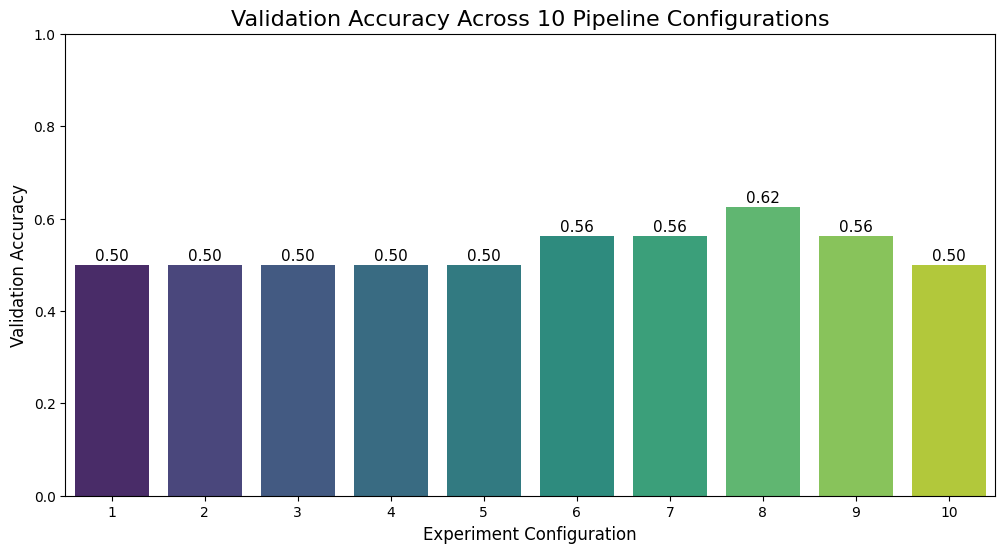

In [8]:
plt.figure(figsize=(12,6))
sns.barplot(x='Config', y='Val Accuracy', data=results, palette='viridis')
plt.ylim(0,1)
plt.title('Validation Accuracy Across 10 Pipeline Configurations', fontsize=16)
plt.xlabel('Experiment Configuration', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)

for i, acc in enumerate(results['Val Accuracy']):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=11)
plt.show()

The bar chart visually shows that Experiment 8 produced the best experiment configuration with a validation accuracy of 0.62.

# Final Evaluation on Test Set (Best Model)
The best performing configuration found in the previous experiments will be used to train a model with that same configuration on the training data. This will provide a comprehensive evaluation of its performance on the unseen test data.

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 119s 661ms/step - accuracy: 0.7118 - loss: 0.6180 - val_accuracy: 0.5000 - val_loss: 0.8360 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 621ms/step - accuracy: 0.7296 - loss: 0.5790 - val_accuracy: 0.5000 - val_loss: 0.7553 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 624ms/step - accuracy: 0.7352 - loss: 0.5694 - val_accuracy: 0.5000 - val_loss: 0.7124 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 658ms/step - accuracy: 0.7282 - loss: 0.5606 - val_accuracy: 0.5000 - val_loss: 0.7993 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 621ms/step - accuracy: 0.7393 - loss: 0.5340 - val_accuracy: 0.5000 - val_loss: 0.7065 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 626ms/step - accuracy: 0.7489 - loss: 0.5195 - val_accuracy: 0.5625 - val_loss: 0.6499 - learning_rate: 1.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 

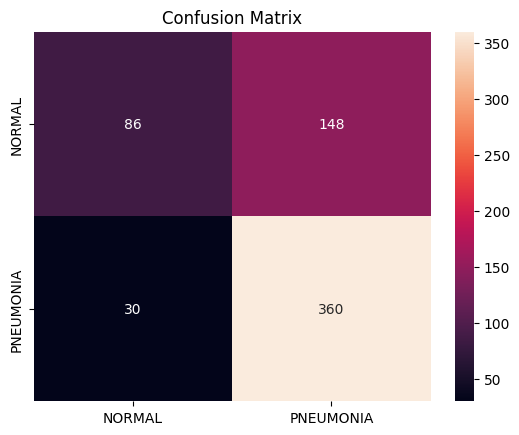

ROC-AUC Score: 0.8408284023668637


In [9]:
# The best model based on results['Val Accuracy'].idxmax()
best_cfg = experiment_configs[results['Val Accuracy'].idxmax()]
train_gen, val_gen, test_gen = get_datagen(best_cfg["aug"], batch_size=best_cfg["batch_size"])

# Rebuild and train the best model
if best_cfg["model_type"] == "EfficientNetB0":
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
else:
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

base_model.trainable = False
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)
best_model = Model(inputs=base_model.input, outputs=output)

best_model.compile(optimizer=Adam(best_cfg["lr"]), loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

best_model.fit(train_gen, validation_data=val_gen, epochs=best_cfg["epochs"], callbacks=[early_stop, reduce_lr])

# Predict on test set
test_gen.reset()
y_pred = best_model.predict(test_gen)
y_pred_classes = (y_pred > 0.5).astype(int)

# Metrics
print("Classification Report:\n")
print(classification_report(test_gen.classes, y_pred_classes, target_names=classes))

cm = confusion_matrix(test_gen.classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.show()

roc_score = roc_auc_score(test_gen.classes, y_pred)
print("ROC-AUC Score:", roc_score)

The **Classification Report** shows that the model achieved an overall accuracy of 71% on the test set.

The model performs better at identifying Pneumonia cases with 71% precision and 92% recall. However, it performs slightly higher for the Normal class with 74% precision and 37% recall.

The **Confusion Matrix** shows the number of correct and incorrect predictions made by the model compared to the actual outcomes. Each part of the confusion matrix represents:

* Top-Left (86): True Negatives (TN)

  The model predicted "NORMAL," and the actual class was "NORMAL." These are correct predictions of the negative class.

* Top-Right (148): False Positives (FP)

The model predicted "PNEUMONIA," but the actual class was "NORMAL." These are incorrect predictions where the model falsely identified a normal case as pneumonia (Type I error).

* Bottom-Left (30): False Negatives (FN)

The model predicted "NORMAL," but the actual class was "PNEUMONIA." These are incorrect predictions where the model failed to identify a pneumonia case (Type II error). This is often a critical error in medical diagnosis.

* Bottom-Right (360): True Positives (TP)
The model predicted "PNEUMONIA," and the actual class was "PNEUMONIA." These are correct predictions of the positive class.

From the confusion matrix, other metrics can be calculated:

Accuracy: (TP + TN) / Total (360 + 86) / 624 ≈ 0.71

Precision (for Pneumonia): TP / (TP + FP) = 360 / (360 + 148) ≈ 0.71

Recall (for Pneumonia): TP / (TP + FN) = 360 / (360 + 30) ≈ 0.92


**ROC-AUC Score** of 0.8408284023668637 suggests that the best model has a good chance of differentiating between NORMAL and PNEUMONIA cases across different classification thresholds.

# Saving Best Model
The best model is saved and tested using chest x-ray images

In [10]:
best_model.save("pneumonia_detector_best.keras")

Load the saved model for inference

In [11]:
from tensorflow.keras.models import load_model

model = load_model("pneumonia_detector_best.keras")

Using the model to predict if some chest x-ray are positive for pneumonia or not

In [12]:
from tensorflow.keras.preprocessing import image

img = image.load_img("new_image.jpeg", target_size=(224,224))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)
print("Pneumonia" if prediction > 0.5 else "Normal")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Pneumonia


In [13]:
img = image.load_img("new_xray.jpeg", target_size=(224,224))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)
print("Pneumonia" if prediction > 0.5 else "Normal")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Pneumonia


In [14]:
img = image.load_img("xray_image.jpeg", target_size=(224,224))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)
print("Pneumonia" if prediction > 0.5 else "Normal")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Pneumonia


# Final Discussion
**Strengths of the Pipeline**

1.   This pipeline leverages **Transfer Learning**. It uses pretrained models such as ResNet50 which provides a strong starting point and also reduces the need for a massive dataset and extensive training from scratch.
2.   The inclusion of **Data Augmentation**. This pipeline incorporates data augmentation techniques which helps to increase the variability of the training data and can improve the model's ability to generalize to unseen images, even though the impact varied across configurations in the experiments.
3.   The application of **Systematic Experimentation**. Testing multiple configurations with different data augmentation, model types, learning rates and batch sizes provide a data-driven selection of the best performing pipeline.
4.   The use of **Clear Evaluation Metrics**. Confusion Matrix, Classification Report and ROC-AUC score provide a comprehensive evaluation of the model's performance on the test set.

**Limitations of the Pipeline**

1.   This pipeline uses only **Feature Extraction**(freezing the base model layers) rather than fine tuning. Although feature extraction is relatively faster, fine tuning may lead to better performance by allowing the pre-trained model to adapt to more specifically the chest x-ray data.
2.   Probability of **Class Imbalance**. Although it has not been explicitly stated in this pipeline, most medical datasets often have class imbalance. If the training data is imbalanced, the model might be biased towards the majority class, potentially impacting performance on the minority class. The classification report shows a difference in precision and recall between the classes, which could be related to imbalance.
3.   This model is defined for **Binary Classification**(Normal/Pneumonia) only. In a real-world scenario, there might be other relevant diagnoses or nuances in the images that this binary model would not capture.
4.  **Valid Accuracy Plateau for EfficientNetB0**. The EfficientNetB0 models consistently showed a validation accuracy of 0.500 which suggests issues with this model or its hyperparameters under the feature extraction approach used.


**Implications of the Results for the Business Problem**

The results show that the best-performing pipeline (Experiment 8 with ResNet50 and flip+zoom augmentation) achieved a test accuracy of 0.71, with a precision of 0.74 and recall of 0.37 for the Pneumonia class, and an ROC-AUC score of 0.84.

1.   An accuracy of 71% suggests that this model has the capability to distinguish between normal and pneumonia cases, indicating a **potential for automating** initial screening or prioritizing urgent cases.
2.   By flagging potential pneumonia cases, the model can help radiologists focus on more complex cases, potentially **reducing report delays**.
3.   Faster reporting can lead to quicker treatment decisions and potentially shorter hospital stays, contributing to **improved operational efficiency**.
4.   The presence of false positives and false negatives shows that the model should be used as a tool to **assist radiologists**, not replace them. False negatives, in particular, are critical in a medical context as they represent missed diagnoses.

**Data-driven Recommendations for solving the Business Problem**

1.   The model should be deployed as a decision-suppot tool rather than an autonomous diagnostic system.
2.   Data Imbalance Investigation.The class distribution in the training data should be analyzed and strategies implemented to address potential imbalance. These strategies can be oversampling the minority class and undersampling the minority class.
3.   Fine tuning of the pre-trained base models should be implemented.Unfreezing and training some or all layers of ResNet50(with a lower learning rate) could potentially improve the performance further by enabling the model to learn more domain-specific features from the chest x-rays.
4.   Data Augmentation should be optimized. Continuous experimentation with different data augmentation techniques and their combinations, potentially including more advanced methods, to find the optimal strategy for improving generalization.

**Most Informative Features of the Model and Model Explainability**

The most informative features identified by the model are complex, high-level patterns automatically learned by the pre-trained convolutional neural network during transfer learning. These features are abstract numerical representations rather than clearly interpretable clinical indicators such as lung opacity or shape.

Consequently, the model functions as a “black box,” and its decision-making process cannot be fully explained in human-understandable terms. While techniques such as Grad-CAM can visually highlight the regions of an image that influenced the prediction, they provide only partial insight into the reasoning behind the classification.

**Deployment of the Model**

Based on the current performance (71% accuracy on the test set) and the critical nature of medical diagnosis, deploying this model for fully autonomous decision-making is not recommended at this stage.

The model shows promise as a tool to assist radiologists, for example, by flagging potential pneumonia cases for prioritized review. However, due to the non-perfect accuracy and the presence of false negatives, human oversight by a qualified radiologist is essential for any real-world application.

Further improvements through fine-tuning, addressing data imbalance, and potentially using more advanced techniques would be necessary before considering deployment, even in an assistive capacity. Any deployment would also require intensive clinical validation and regulatory approval.